# 1. Library Imports

In [1]:
import pandas as pd
import nltk
import plotly.express as px
import matplotlib.pyplot as plt
import string
import plotly.graph_objs as go
import certifi
import os

from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from plotly.subplots import make_subplots


os.environ["SSL_CERT_FILE"] = certifi.where()
nltk.download('opinion_lexicon')
nltk.download('vader_lexicon')

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/rodrigofranciozi/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rodrigofranciozi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# 2. Dataset import

In [2]:
df_reviews = pd.read_csv('Data/cleaned_reviews.csv')

print(df_reviews.shape)
df_reviews.head()

(14480, 2)


comments   
0  talk to me is a stone cold classic of the horr...  \
1  a group of youngsters discover that by taking ...   
2  danny and michael philippou have truly made so...   
3  i watched talk to me early as part of regals m...   
4  the premise was what initially drew me to this...   

                                       comments_stop  
0  talk stone cold classic horror genre feels fre...  
1  group youngsters discover taking part small ri...  
2  danny michael philippou truly made something s...  
3  watched talk early part regals mystery movie m...  
4  premise initially drew film although different...

# 3. Most Common Words

In [3]:
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

In [4]:
# Apply tokenization to each comment
df_reviews['tokens'] = df_reviews['comments_stop'].apply(tokenize_text)

# Flatten the list of tokens
all_words = [word for tokens in df_reviews['tokens'] for word in tokens]

# Count word frequencies
word_counts = Counter(all_words)

# Convert to DataFrame
df_most_common_words = pd.DataFrame(word_counts.most_common(10), columns=['word', 'frequency'])

In [5]:
df_most_common_words.T

0      1      2     3     4       5       6      7     8     9
word       movie   film   like   one  good  horror  really  story  even  time
frequency  29363  15942  12339  9907  9098    8417    7722   7105  6082  6036

# 4. Lexicon-based technique

2 different techniques were chosen to apply and compare:
- Opinion Lexicon;
- Vader;

Both were applied using the steeming technique to increase classification performance.

In [6]:
def plot_word_cloud(df, sentiment, comment, title_fontsize=16):
    
    # Set up subplots with 1 column and 3 rows
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))
    
    for i, ax in enumerate(axes.flatten()):
        # Concatenate all text from the 'text_column'
        text = " ".join(df[df[sentiment] == df[sentiment].unique()[i]][comment])
        
        # Create a WordCloud object
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
        
        # Display the generated word cloud using the subplot
        ax.imshow(wordcloud, interpolation='bilinear')
        
        # Set the title for the subplot with a custom fontsize
        ax.set_title('Word Cloud for Sentiment: {}'.format(df[sentiment].unique()[i]), fontsize=title_fontsize) 
        ax.axis("off") # Turn off axis labels

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

In [7]:
# Creating a custom list
custom_stop_words = ['film', 'movie', 'one', 'like', 'horror', 'story', 'even', 'time']

In [8]:
# Define a function to remove custom stop words
def remove_stop_words_custom(text):
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in custom_stop_words]
    return ' '.join(filtered_text)

In [9]:
# Apply the function to the desired column
df_reviews['comments_stop_custom'] = df_reviews['comments_stop'].apply(remove_stop_words_custom)

df_reviews.head()

comments   
0  talk to me is a stone cold classic of the horr...  \
1  a group of youngsters discover that by taking ...   
2  danny and michael philippou have truly made so...   
3  i watched talk to me early as part of regals m...   
4  the premise was what initially drew me to this...   

                                       comments_stop   
0  talk stone cold classic horror genre feels fre...  \
1  group youngsters discover taking part small ri...   
2  danny michael philippou truly made something s...   
3  watched talk early part regals mystery movie m...   
4  premise initially drew film although different...   

                                              tokens   
0  [talk, stone, cold, classic, horror, genre, fe...  \
1  [group, youngsters, discover, taking, part, sm...   
2  [danny, michael, philippou, truly, made, somet...   
3  [watched, talk, early, part, regals, mystery, ...   
4  [premise, initially, drew, film, although, dif...   

                                comments_stop_custom  
0  talk stone cold classic genre feels fresh thri...  
1  group youngsters discover taking part small ri...  
2  danny michael philippou truly made something s...  
3  watched talk early part regals mystery monday ...  
4  premise initially drew although different simi...

## Opinion Lexicon

In [10]:
# Expand and Refine the Lexicon with specific lexicon dictionary and stemming
porter = PorterStemmer()

positive_words_stemmed = set([porter.stem(word) for word in opinion_lexicon.positive()])
negative_words_stemmed = set([porter.stem(word) for word in opinion_lexicon.negative()])


# Define a function to get the sentiment score and label of a sentence
def opinion_lexicon_with_stemming(sentence):
    words = word_tokenize(sentence)
    stemmed_words = [porter.stem(word) for word in words]
    
    # Count positive and negative words
    num_positive = sum(1 for word in stemmed_words if word in positive_words_stemmed)
    num_negative = sum(1 for word in stemmed_words if word in negative_words_stemmed)
    
    # Calculate sentiment score
    sentiment_score = num_positive - num_negative
    
    # Assign sentiment label based on the score
    if sentiment_score > 0:
        sentiment_label = 'Positive'
    elif sentiment_score < 0:
        sentiment_label = 'Negative'
    else:
        sentiment_label = 'Neutral'
    
    return sentiment_label

### Standard

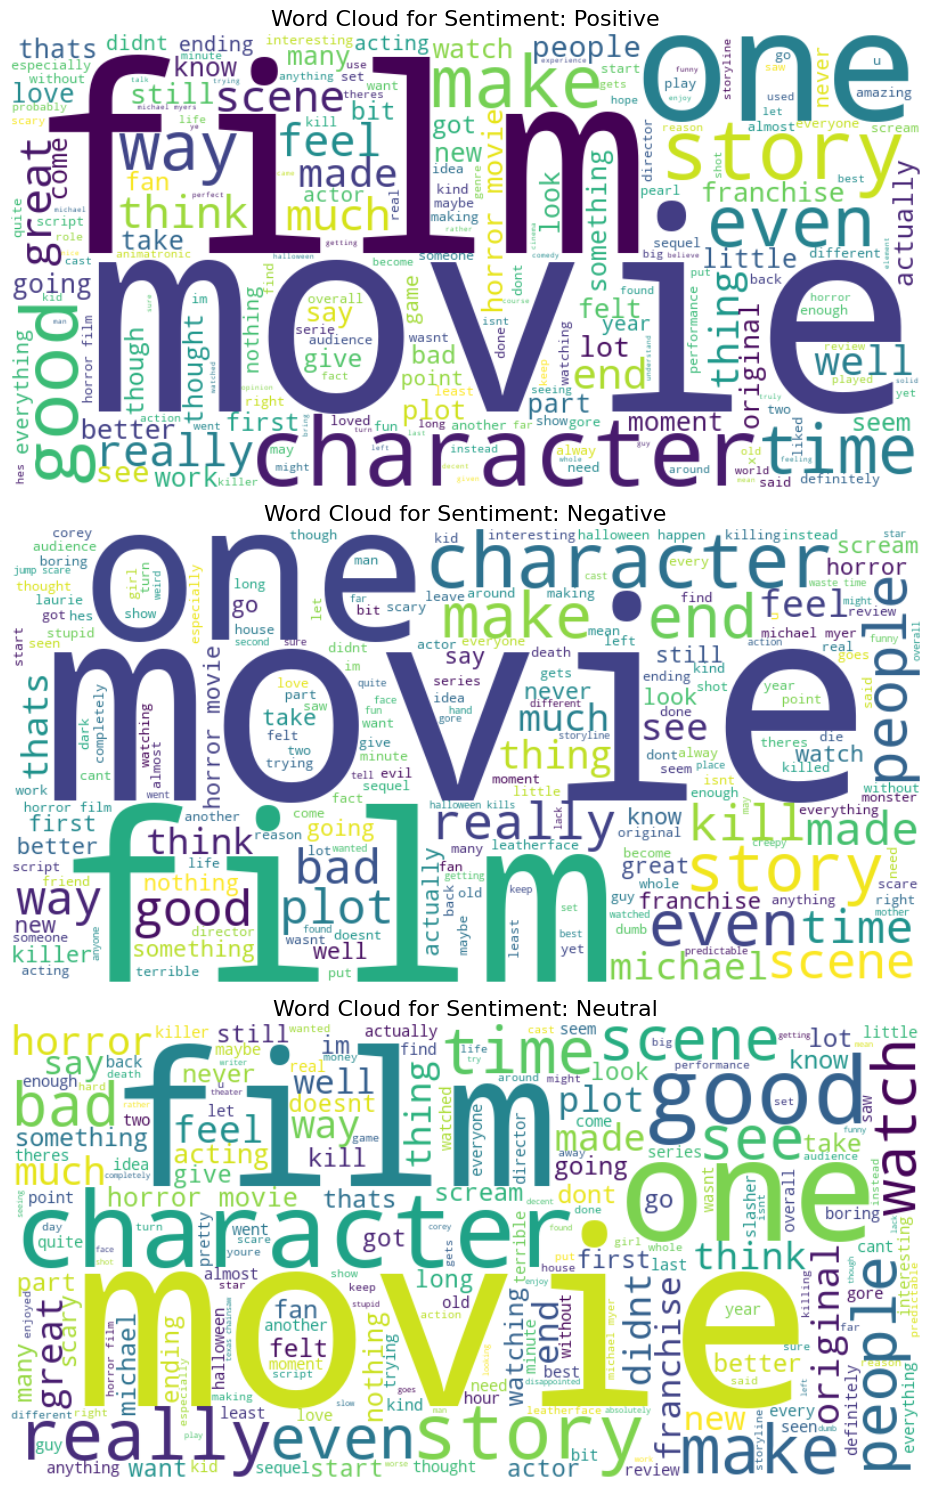

In [11]:
# Apply refined sentiment analysis to each review
df_reviews['sentiment_opinion_standard'] = df_reviews['comments_stop'].apply(opinion_lexicon_with_stemming)

plot_word_cloud(df_reviews, 'sentiment_opinion_standard', 'comments_stop')

It's becomes visible that some of the most common words were also classified as having a high frequency in all comments: **film**, **movie** and **one**.

### Custom

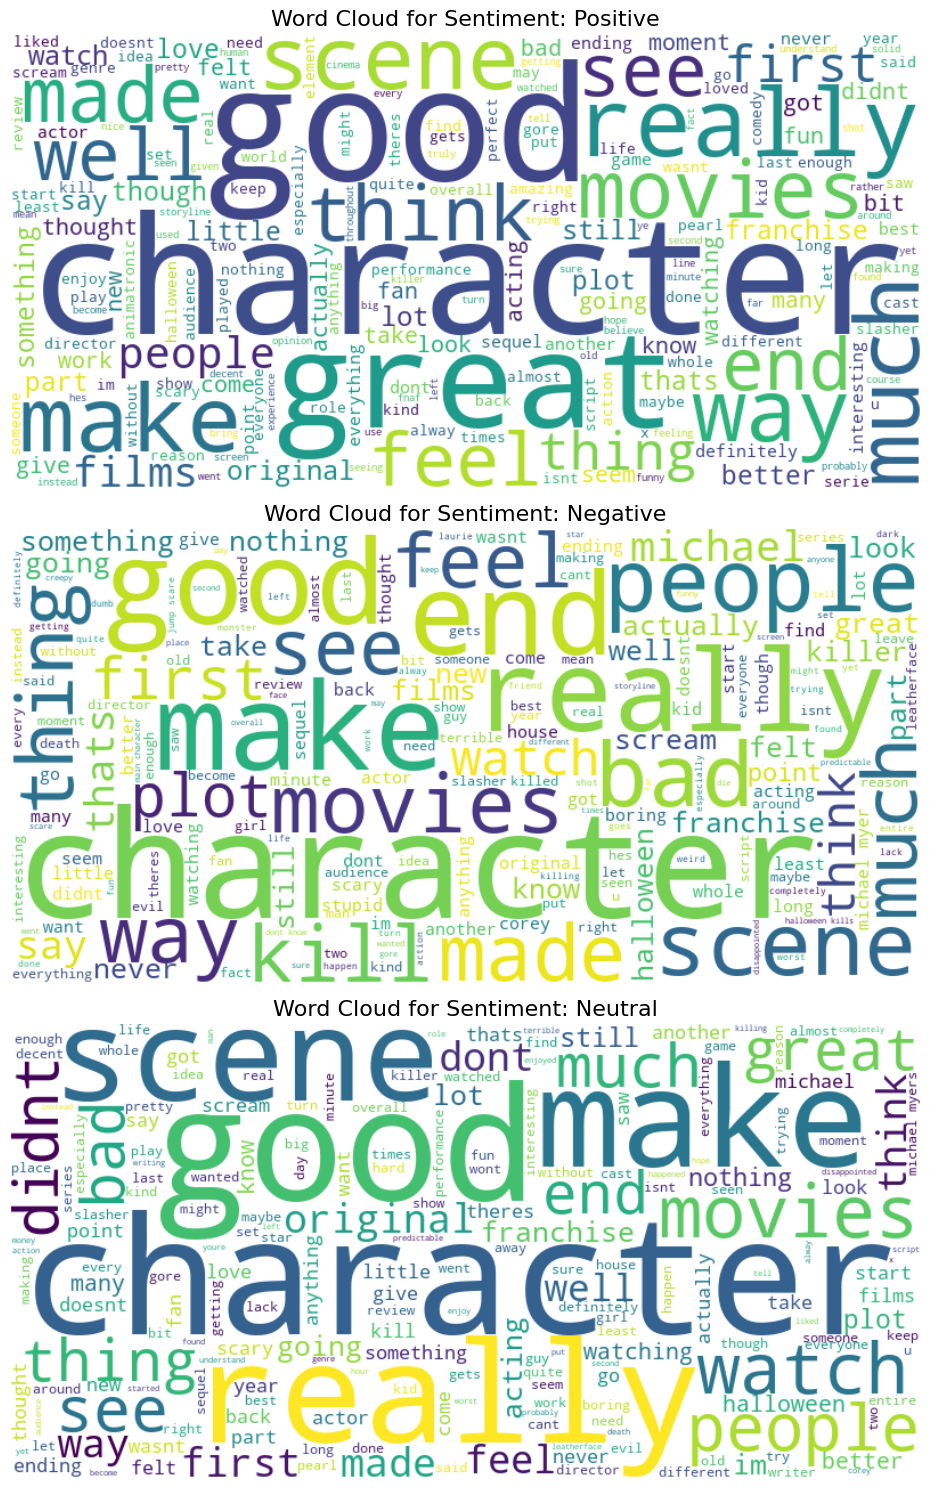

In [12]:
# Apply refined sentiment analysis to each review
df_reviews['sentiment_opinion_custom'] = df_reviews['comments_stop_custom'].apply(opinion_lexicon_with_stemming)

plot_word_cloud(df_reviews, 'sentiment_opinion_custom', 'comments_stop_custom')

## Vader

In [13]:
def vader_sentiment_with_stemming(text):
    
    # Initialize the Sentiment Intensity Analyzer
    sid = SentimentIntensityAnalyzer()
    
    # Initialize the Porter stemmer
    porter = PorterStemmer()
    
    # Tokenize and stem the words
    words = word_tokenize(text)
    stemmed_words = [porter.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)
    
    # Apply sentiment analysis to the stemmed text
    compound_score = sid.polarity_scores(stemmed_text)['compound']
    
    # Map compound score to sentiment label
    if compound_score > 0.0:
        sentiment_label = 'Positive'
    elif compound_score < 0.0:
        sentiment_label = 'Negative'
    else:
        sentiment_label = 'Neutral'
    
    return sentiment_label

### Standard

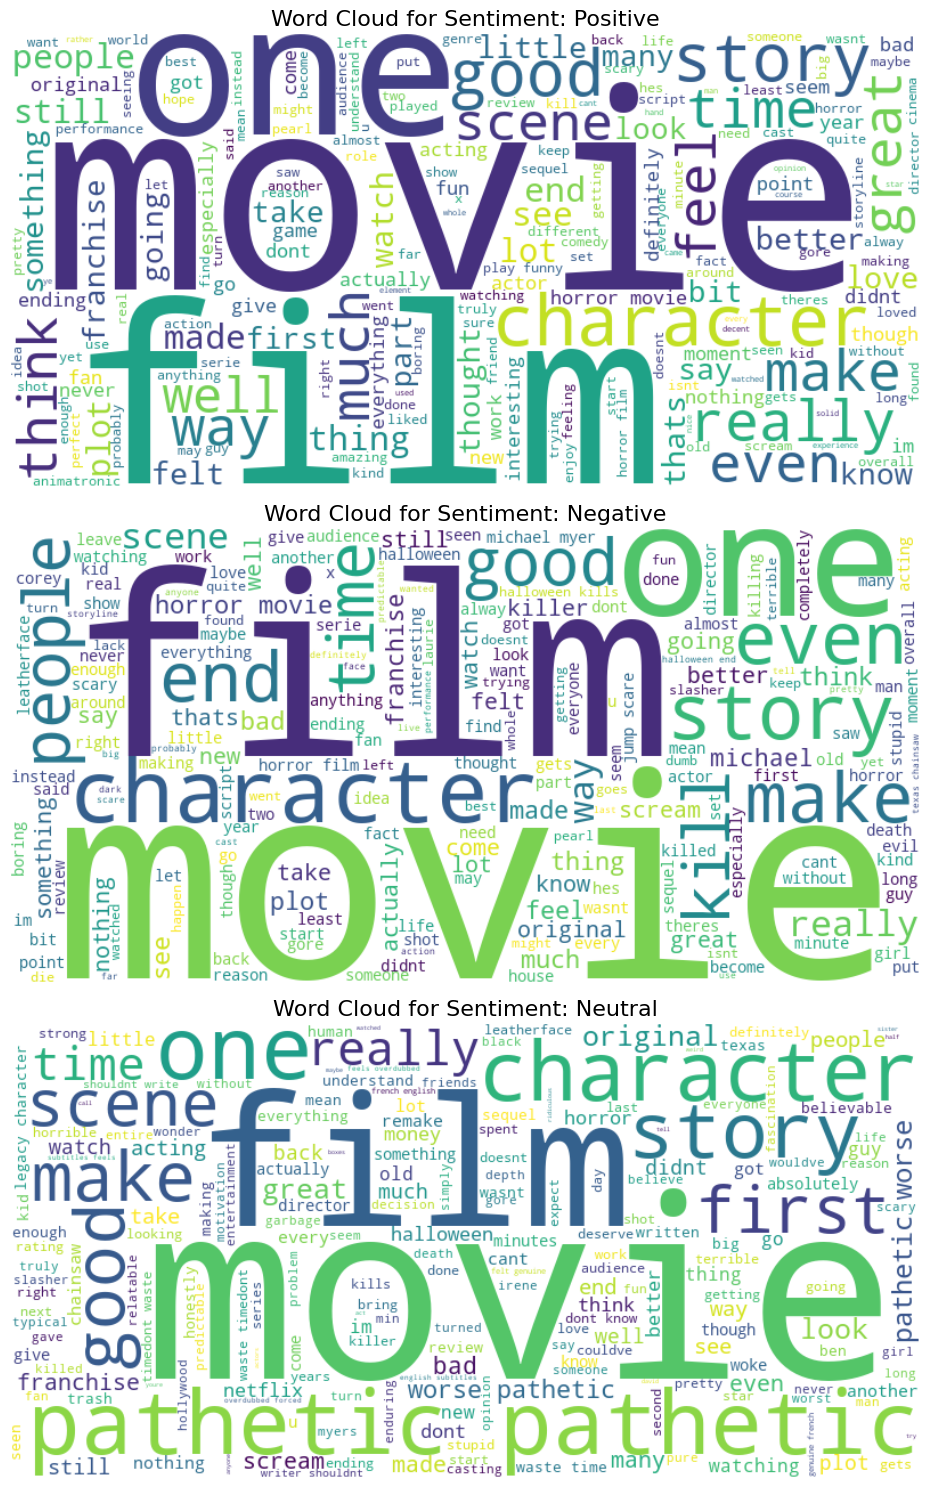

In [14]:
# Apply refined sentiment analysis to each review
df_reviews['sentiment_vader_standard'] = df_reviews['comments_stop'].apply(vader_sentiment_with_stemming)

plot_word_cloud(df_reviews, 'sentiment_vader_standard', 'comments_stop')

### Custom

In [ ]:
# Apply refined sentiment analysis to each review
df_reviews['sentiment_vader_custom'] = df_reviews['comments_stop_custom'].apply(vader_sentiment_with_stemming)

plot_word_cloud(df_reviews, 'sentiment_vader_custom', 'comments_stop_custom')

# 5. Plot polarity results

In [ ]:
df_plot = pd.concat([
    df_reviews.sentiment_opinion_standard.value_counts().reset_index().rename(columns={'sentiment_opinion_standard': 'sentiment', 'count': 'amount'}).assign(classification = 'Opinion_Lexic_Standard'),
    df_reviews.sentiment_opinion_custom.value_counts().reset_index().rename(columns={'sentiment_opinion_custom': 'sentiment', 'count': 'amount'}).assign(classification = 'Opinion_Lexic_Custom'),
    df_reviews.sentiment_vader_standard.value_counts().reset_index().rename(columns={'sentiment_vader_standard': 'sentiment', 'count': 'amount'}).assign(classification = 'Vader_Standard'),
    df_reviews.sentiment_vader_custom.value_counts().reset_index().rename(columns={'sentiment_vader_custom': 'sentiment', 'count': 'amount'}).assign(classification = 'Vader_Custom')
                   ])

In [ ]:
# Extracting data for each classification
opinion_lexic_standard = df_plot.loc[df_plot['classification'] == 'Opinion_Lexic_Standard', 'amount'].tolist()
opinion_lexic_custom = df_plot.loc[df_plot['classification'] == 'Opinion_Lexic_Custom', 'amount'].tolist()
vader_standard = df_plot.loc[df_plot['classification'] == 'Vader_Standard', 'amount'].tolist()
vader_custom = df_plot.loc[df_plot['classification'] == 'Vader_Custom', 'amount'].tolist()

# Custom colors for bars
color_opinion_lexic_standard = '#336799'
color_opinion_lexic_custom = '#ED7D31'
color_vader_standard = '#336799'
color_vader_custom = '#ED7D31'

# Create subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=['Opinion Lexic Standard', 'Opinion Lexic Custom', 'Vader Standard', 'Vader Custom'])

# Add traces to the subplots
fig.add_trace(go.Bar(x=['Positive', 'Negative', 'Neutral'], y=opinion_lexic_standard, name='Opinion_Lexic_Standard',
                     text=opinion_lexic_standard, textposition='auto', marker=dict(color=color_opinion_lexic_standard)), row=1, col=1)
fig.add_trace(go.Bar(x=['Positive', 'Negative', 'Neutral'], y=opinion_lexic_custom, name='Opinion_Lexic_Custom',
                     text=opinion_lexic_custom, textposition='auto', marker=dict(color=color_opinion_lexic_custom)), row=1, col=2)
fig.add_trace(go.Bar(x=['Positive', 'Negative', 'Neutral'], y=vader_standard, name='Vader_Standard',
                     text=vader_standard, textposition='auto', marker=dict(color=color_vader_standard)), row=2, col=1)
fig.add_trace(go.Bar(x=['Positive', 'Negative', 'Neutral'], y=vader_custom, name='Vader_Custom',
                     text=vader_custom, textposition='auto', marker=dict(color=color_vader_custom)), row=2, col=2)

# Update layout
fig.update_layout(title_text='Sentiment Analysis by Classification Technique', showlegend=False, height=600, width=1050)

# 6. Data Export

In [ ]:
df_reviews[['comments_stop', 'sentiment_opinion_standard']]\
    .rename(columns={'comments_stop': 'reviews', 'Opinion_Lexic_Custom': 'sentiment'})\
    .to_csv('Data/model_reviews.csv', index=False)